In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore, t

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import IsolationForest

from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.neighbors import LocalOutlierFactor


from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
columns = ['mpg','cylinders','displacement','horsepower','weight','acceleration','year','origin','name']
df = pd.read_csv(uploaded,delim_whitespace=True,names=columns)

#drop name column
df.drop(columns=['name'],inplace=True)

columns = ['cylinders','displacement','horsepower','weight','acceleration','year','origin']
print(df.shape)
df.dtypes

(398, 8)


mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
year              int64
origin            int64
dtype: object

In [3]:
df.horsepower.unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

In [4]:
df=df[df['horsepower']!='?']
df['horsepower']=df['horsepower'].astype('float')
df.isnull().any()

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
year            False
origin          False
dtype: bool

In [5]:
df[columns]=StandardScaler().fit_transform(df[columns])

#apply z-score outlier treatment
z = np.abs(zscore(df))
df = df[(z < 3).all(axis=1)]

print(df.shape)
df.head()

(385, 8)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,1.483947,1.077290,0.664133,0.620540,-1.285258,-1.625315,-0.716641
1,15.0,1.483947,1.488732,1.574594,0.843334,-1.466724,-1.625315,-0.716641
2,18.0,1.483947,1.182542,1.184397,0.540382,-1.648189,-1.625315,-0.716641
3,16.0,1.483947,1.048584,1.184397,0.536845,-1.285258,-1.625315,-0.716641
4,17.0,1.483947,1.029447,0.924265,0.555706,-1.829655,-1.625315,-0.716641


In [6]:
X_orig=df[columns]
y=df['mpg']
print(X_orig.shape)
pd.DataFrame(data=[X_orig.skew(),X_orig.kurtosis()],index=['skewness','kurtosis'])

(385, 7)


,cylinders,displacement,horsepower,weight,acceleration,year,origin
skewness,0.533598,0.672639,0.971972,0.531125,0.227886,0.012683,0.902325
kurtosis,-1.357577,-0.870397,0.326162,-0.783535,0.184673,-1.158124,-0.873909


In [7]:
outliers = LocalOutlierFactor(n_neighbors=20).fit_predict(X_orig)
target_out = LocalOutlierFactor(n_neighbors=20).fit_predict(y.values.reshape(-1,1))

outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t

X_orig,y=X_orig[outliers],y[outliers]
X_orig.shape

(320, 7)

In [8]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_orig.values, i) for i in range(X_orig.shape[1])]
vif["features"] = pd.Index(X_orig.columns)
vif

,VIF Factor,features
0,14.661519,cylinders
1,32.023998,displacement
2,12.659435,horsepower
3,15.306702,weight
4,2.569829,acceleration
5,1.191453,year
6,1.766854,origin


In [9]:
# Highest VIF>= 10 value is for displacement(25.1), remove displacement
# 'cylinders','displacement','horsepower','weight','acceleration','year','origin'
X = X_orig.drop(['displacement'],axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = pd.Index(X.columns)
vif

,VIF Factor,features
0,6.202541,cylinders
1,12.326856,horsepower
2,11.942000,weight
3,2.495130,acceleration
4,1.187826,year
5,1.597398,origin


In [10]:
# Highest VIF>=10 value is for horsepower(VIF=11.6), remove horsepower
# 'cylinders','displacement','horsepower','weight','acceleration','year','origin'
X = X.drop(['horsepower'],axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = pd.Index(X.columns)
vif

,VIF Factor,features
0,6.105073,cylinders
1,5.708305,weight
2,1.380682,acceleration
3,1.123829,year
4,1.539061,origin


In [11]:
k=X.shape[1]
acc_metric = 'neg_mean_squared_error'
# acc_metric = 'neg_mean_absolute_error'
cv = KFold(n_splits=10, shuffle= True,random_state=100)
model_selected=None
minRMSE=np.inf
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])

try:
    X=X.to_numpy()
except:
    pass
try:
    y=y.to_numpy()
except:
    pass
X.shape

(320, 5)

In [12]:
def get_soc(final_clf, features):
    soc = 0
    n = 7     # for tanh
    if( final_clf.get_params()['activation'] == 'relu' ):
      n = 1
    elif ( final_clf.get_params()['activation'] == 'logistic' ):
      n = 3

    for i in final_clf.get_params()['hidden_layer_sizes']:
      soc += ( 2 * features + n * i )
      features = i
    soc += 2 * features * final_clf.n_outputs_
    return soc

In [13]:
arr_mse = []
arr_mae = []
arr_soc = []
arr_hls = []

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100, 100), 'learning_rate_init': 0.002154434690031882}


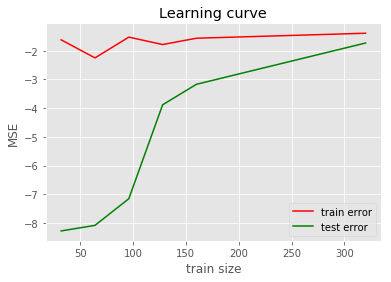

mse :  5.967279540355358
mae :  1.8501569403554512
soc :  1210


In [14]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_1 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100), (100, 100, 100, 100), (100, 100, 100, 100, 100)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_1, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50, 50), 'learning_rate_init': 0.001291549665014884}


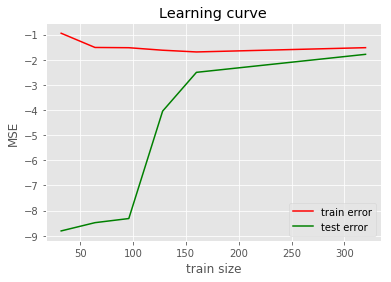

mse :  6.357414785151162
mae :  1.7884720797170153
soc :  610


In [15]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_2 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(50, 50, 50, 50), (100, 100, 100, 100), (150, 150, 150, 150)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_2, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (75, 75, 75, 75), 'learning_rate_init': 0.000774263682681127}


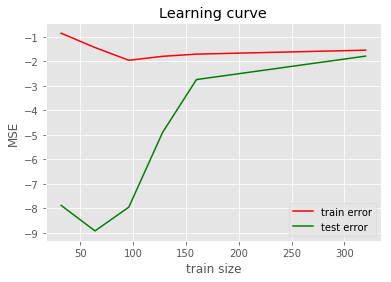

mse :  6.211623277465856
mae :  1.7737071811184777
soc :  910


In [18]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_3 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(25,25,25,25), (50,50,50,50), (75,75,75,75)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_3, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (85, 85, 85, 85), 'learning_rate_init': 0.00046415888336127773}


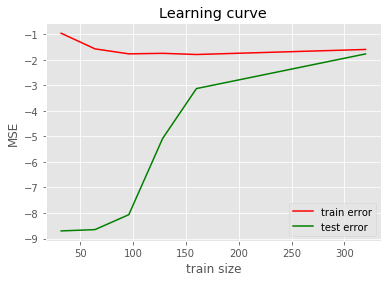

mse :  6.373678049661669
mae :  1.8167754414118928
soc :  1030


In [23]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_4 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(65,65,65,65), (85,85,85,85), (75,75,75,75)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_4, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (90, 90, 90, 90), 'learning_rate_init': 0.001291549665014884}


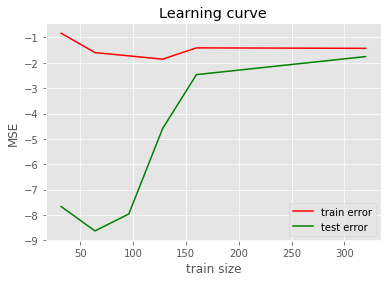

mse :  5.7534018797287425
mae :  1.8883323455226688
soc :  1090


In [24]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_5 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(80,80,80,80), (85,85,85,85), (70,70,70,70), (90,90,90,90)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_5, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (70, 70, 70, 70), 'learning_rate_init': 0.000774263682681127}


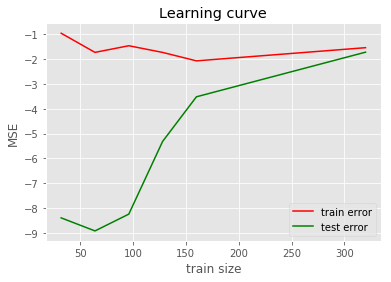

mse :  6.225882745790351
mae :  1.8705487717763938
soc :  850


In [25]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_6 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(73,73,73,73), (77,77,77,7), (70,70,70,70)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_6, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')t
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50, 50), 'learning_rate_init': 0.002154434690031882}


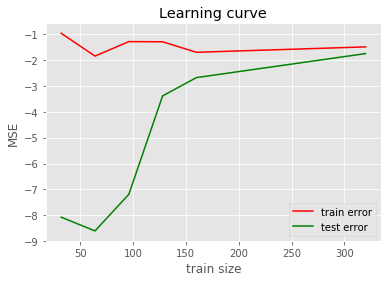

mse :  5.830477684167201
mae :  1.830370321723611
soc :  610


In [27]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(100,100,100), (50,50,50,50), (50,50,50)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.001291549665014884}


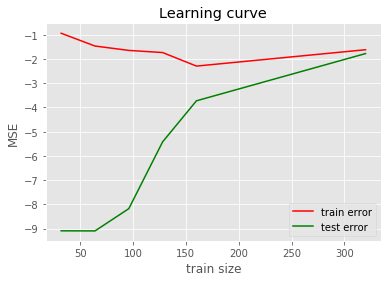

mse :  6.676224119817661
mae :  1.8357588080252978
soc :  460


In [28]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(100,100),(50,50,50)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}


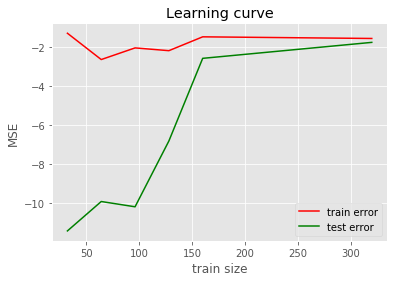

mse :  6.341425299826534
mae :  1.8510252981339548
soc :  310


In [29]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(50,50),(100,), (10,10,10)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01}


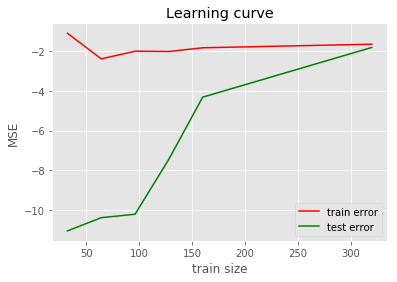

mse :  6.673109758390455
mae :  1.9100406552393767
soc :  160


In [30]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(50,),(10,), (10,10)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.005994842503189409}


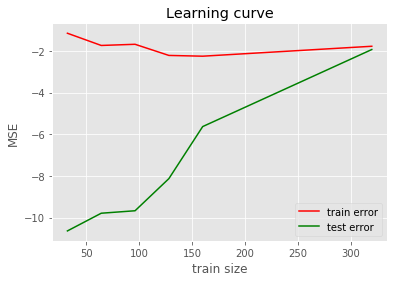

mse :  7.4022490857287435
mae :  1.9700491617414155
soc :  70


In [31]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(20,),(10,), (10,10)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (20, 20), 'learning_rate_init': 0.01}


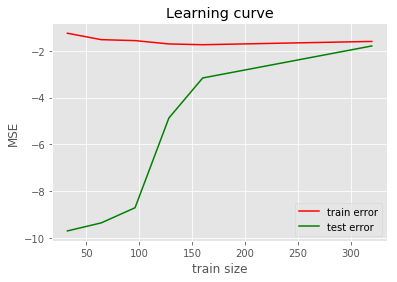

mse :  6.074150435551706
mae :  1.8671834288314155
soc :  130


In [40]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(20,20),(10,),(25,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (15, 15), 'learning_rate_init': 0.005994842503189409}


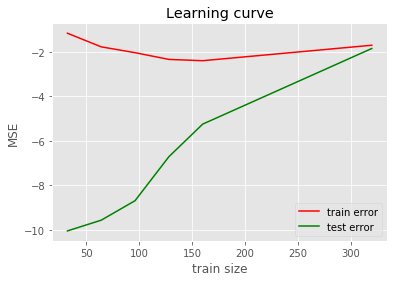

mse :  6.338699595689919
mae :  1.914349637734422
soc :  100


In [41]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(15,15),(25,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (12, 12), 'learning_rate_init': 0.01}


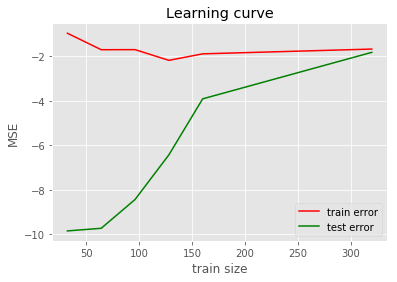

mse :  6.778219229167203
mae :  1.933352355786728
soc :  82


In [42]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(12,12),(20,),(5,5,5)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (11, 11), 'learning_rate_init': 0.01}


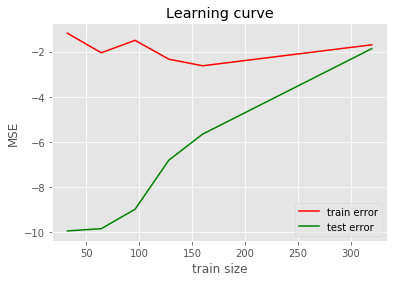

mse :  6.911251886788146
mae :  1.8931515812263904
soc :  76


In [43]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(11,11),(21,),(22),(7,7,7)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.01}


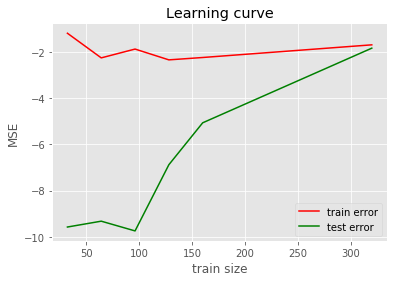

mse :  6.224176763677913
mae :  1.8716991054530627
soc :  70


In [44]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(10,10)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (5, 5), 'learning_rate_init': 0.01}


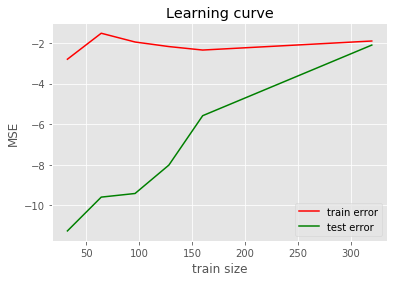

mse :  6.89943672403767
mae :  2.0552448777105012
soc :  40


In [45]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(5,5),(10)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (8, 8), 'learning_rate_init': 0.01}


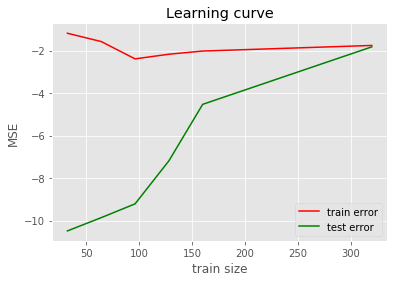

mse :  6.906518979492636
mae :  1.8981976315865565
soc :  58


In [46]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(7,7,),(8,8),(10)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (7, 7), 'learning_rate_init': 0.01}


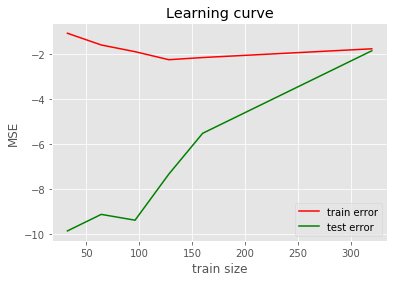

mse :  6.706510374326724
mae :  1.906444019830706
soc :  52


In [47]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(7,7,),(15,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (6, 6), 'learning_rate_init': 0.01}


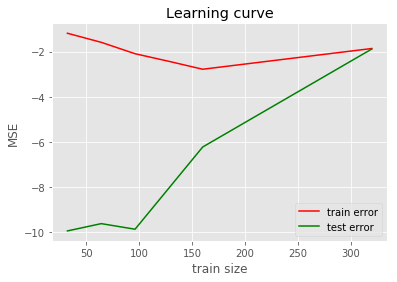

mse :  6.727969351590301
mae :  1.9996059174279441
soc :  46


In [50]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(6,6,),(12,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (3, 3, 3), 'learning_rate_init': 0.003593813663804626}


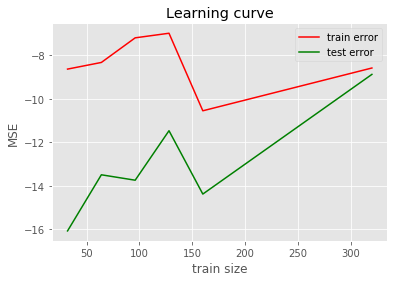

mse :  62.51349065932667
mae :  4.68606649235077
soc :  37


In [51]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(3,3,3), (2,2,2),(1,1,1,1),(2,2,2,2)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

In [77]:
X = X_orig.drop(['displacement', 'horsepower'],axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = pd.Index(X.columns)
vif

,VIF Factor,features
0,6.105073,cylinders
1,5.708305,weight
2,1.380682,acceleration
3,1.123829,year
4,1.539061,origin


In [78]:
X = X.drop(['cylinders'],axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = pd.Index(X.columns)
vif

,VIF Factor,features
0,1.895629,weight
1,1.291855,acceleration
2,1.087871,year
3,1.512814,origin


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (7, 7), 'learning_rate_init': 0.01}


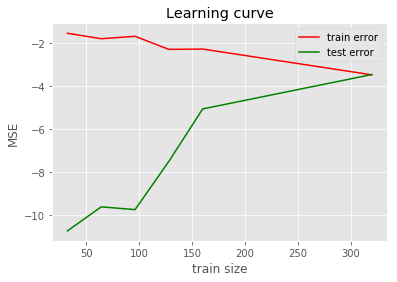

mse :  6.41347360441255
mae :  1.9200871098172825
soc :  50


In [81]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(7,7)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 4)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

In [82]:
X = X.drop(['weight'],axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = pd.Index(X.columns)
vif

,VIF Factor,features
0,1.077810,acceleration
1,1.057674,year
2,1.046145,origin


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (7, 7), 'learning_rate_init': 0.01}


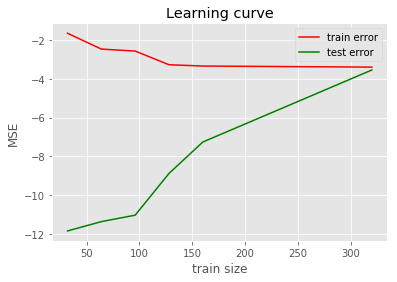

mse :  20.006972231464935
mae :  3.7040791205811425
soc :  48


In [83]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(7,7)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 3)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

In [84]:
del arr_mse[-1]
del arr_mae[-1]
del arr_soc[-1]
del arr_hls[-1]

In [85]:
arr_mae, arr_soc

([1.8501569403554512,
  1.7884720797170153,
  1.7737071811184777,
  1.8167754414118928,
  1.8883323455226688,
  1.8705487717763938,
  1.830370321723611,
  1.8357588080252978,
  1.8510252981339548,
  1.9100406552393767,
  1.9700491617414155,
  1.8671834288314155,
  1.914349637734422,
  1.933352355786728,
  1.8931515812263904,
  1.8716991054530627,
  2.0552448777105012,
  1.8981976315865565,
  1.906444019830706,
  1.9996059174279441,
  1.9200871098172825],
 [1210,
  610,
  910,
  1030,
  1090,
  850,
  610,
  460,
  310,
  160,
  70,
  130,
  100,
  82,
  76,
  70,
  40,
  58,
  52,
  46,
  50])

In [86]:
arr_mae_min = [1.7737071811184777]
arr_soc_min = [910]
arr_mae_min_soc = [1.9200871098172825]
arr_soc_min_soc = [50]

In [87]:
arr_mae_not_allowed = [ x for x in arr_mae if x >= arr_mae_min[0]*1.1 ]
arr_mae_not_allowed

[1.9700491617414155, 2.0552448777105012, 1.9996059174279441]

In [88]:
arr_mae_not_allowed_soc = [70,40,46]

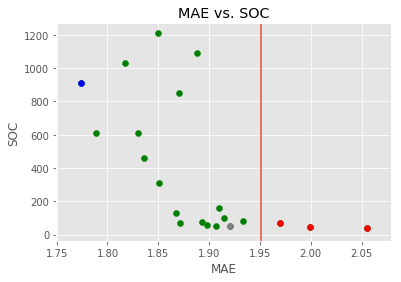

In [89]:
plt.title("MAE vs. SOC")

plt.scatter(arr_mae, arr_soc, c='green')
plt.scatter(arr_mae_not_allowed, arr_mae_not_allowed_soc, c='red')
plt.scatter(arr_mae_min, arr_soc_min, c='blue')
plt.scatter(arr_mae_min_soc, [50], c='grey')
plt.axvline(x=arr_mae_min[0]*1.1)
plt.xlabel('MAE')
plt.ylabel('SOC')
plt.show()

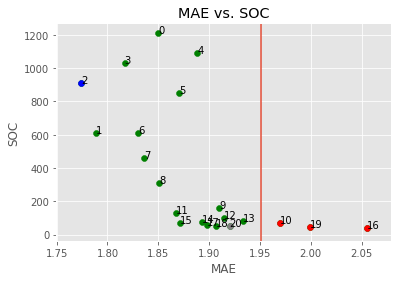

In [90]:
plt.title("MAE vs. SOC")

plt.scatter(arr_mae, arr_soc, c='green')
plt.scatter(arr_mae_not_allowed, arr_mae_not_allowed_soc, c='red')
plt.scatter(arr_mae_min, arr_soc_min, c='blue')
plt.scatter(arr_mae_min_soc, [50], c='grey')
plt.axvline(x=arr_mae_min[0]*1.1)

for i, txt in enumerate(arr_mae):
    plt.annotate(i, (arr_mae[i], arr_soc[i]))

plt.xlabel('MAE')
plt.ylabel('SOC')
plt.show()

In [91]:
data = { 'MAE': arr_mae, 'SOC': arr_soc, 'Hidden Layer Size ': arr_hls }
df = pd.DataFrame(data)
df

,MAE,SOC,Hidden Layer Size
0,1.850157,1210,"(100, 100, 100, 100)"
1,1.788472,610,"(50, 50, 50, 50)"
2,1.773707,910,"(75, 75, 75, 75)"
3,1.816775,1030,"(85, 85, 85, 85)"
4,1.888332,1090,"(90, 90, 90, 90)"
5,1.870549,850,"(70, 70, 70, 70)"
6,1.830370,610,"(50, 50, 50, 50)"
7,1.835759,460,"(50, 50, 50)"
8,1.851025,310,"(100,)"
9,1.910041,160,"(50,)"
